In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'

In [18]:
def exp_form(x):
    return f'{abs(x):.2f} * exp({np.angle(x)/np.pi:.2f} * pi)'

def kn0(beams:np.array, shift_powers:np.array=None) -> tuple[complex, np.array, dict[np.array]]:
    x = [None] + list(beams)
    p = [None] + list(np.array(shift_powers) * np.pi)
    i = 1j
    exp = np.exp
    pi = np.pi

    N1a = 1/np.sqrt(2) * (x[1] * exp(i*p[1]) + x[2] * exp(i*p[2]))
    N1b = 1/np.sqrt(2) * (x[1] * exp(i*p[1]) - x[2] * exp(i*p[2]))
    N2a = 1/np.sqrt(2) * (x[3] * exp(i*p[3]) + x[4] * exp(i*p[4]))
    N2b = 1/np.sqrt(2) * (x[3] * exp(i*p[3]) - x[4] * exp(i*p[4]))

    N3a = 1/np.sqrt(2) * (N1a * exp(i*p[5]) + N2a * exp(i*p[7]))
    N3b = 1/np.sqrt(2) * (N1a * exp(i*p[5]) - N2a * exp(i*p[7]))
    N4a = 1/np.sqrt(2) * (N1b * exp(i*p[6]) + N2b * exp(i*p[8]))
    N4b = 1/np.sqrt(2) * (N1b * exp(i*p[6]) - N2b * exp(i*p[8]))

    S1a = 1/2 * (N3b * exp(i*(p[9]+pi/4)) + N4a * exp(i*(p[11]-pi/4)))
    S1b = 1/2 * (N3b * exp(i*(p[9]-pi/4)) + N4a * exp(i*(p[11]+pi/4)))
    S2a = 1/2 * (N3b * exp(i*(p[10]+pi/4)) + N4b * exp(i*(p[13]-pi/4)))
    S2b = 1/2 * (N3b * exp(i*(p[10]-pi/4)) + N4b * exp(i*(p[13]+pi/4)))
    S3a = 1/2 * (N4a * exp(i*(p[12]+pi/4)) + N4b * exp(i*(p[14]-pi/4)))
    S3b = 1/2 * (N4a * exp(i*(p[12]-pi/4)) + N4b * exp(i*(p[14]+pi/4)))

    return N3a, [S1a, S1b, S2a, S2b, S3a, S3b], {"first_nuller_layer":[N1a, N1b, N2a, N2b],"second_nuller_layer":[N3a, N3b, N4a, N4b]}

In [19]:
star_light = np.array([
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
], dtype=complex)

planet_light = np.array([
    np.exp(1j * 0.10),
    np.exp(1j * -0.12),
    np.exp(1j * 0.05),
    np.exp(1j * -0.01),
], dtype=complex)

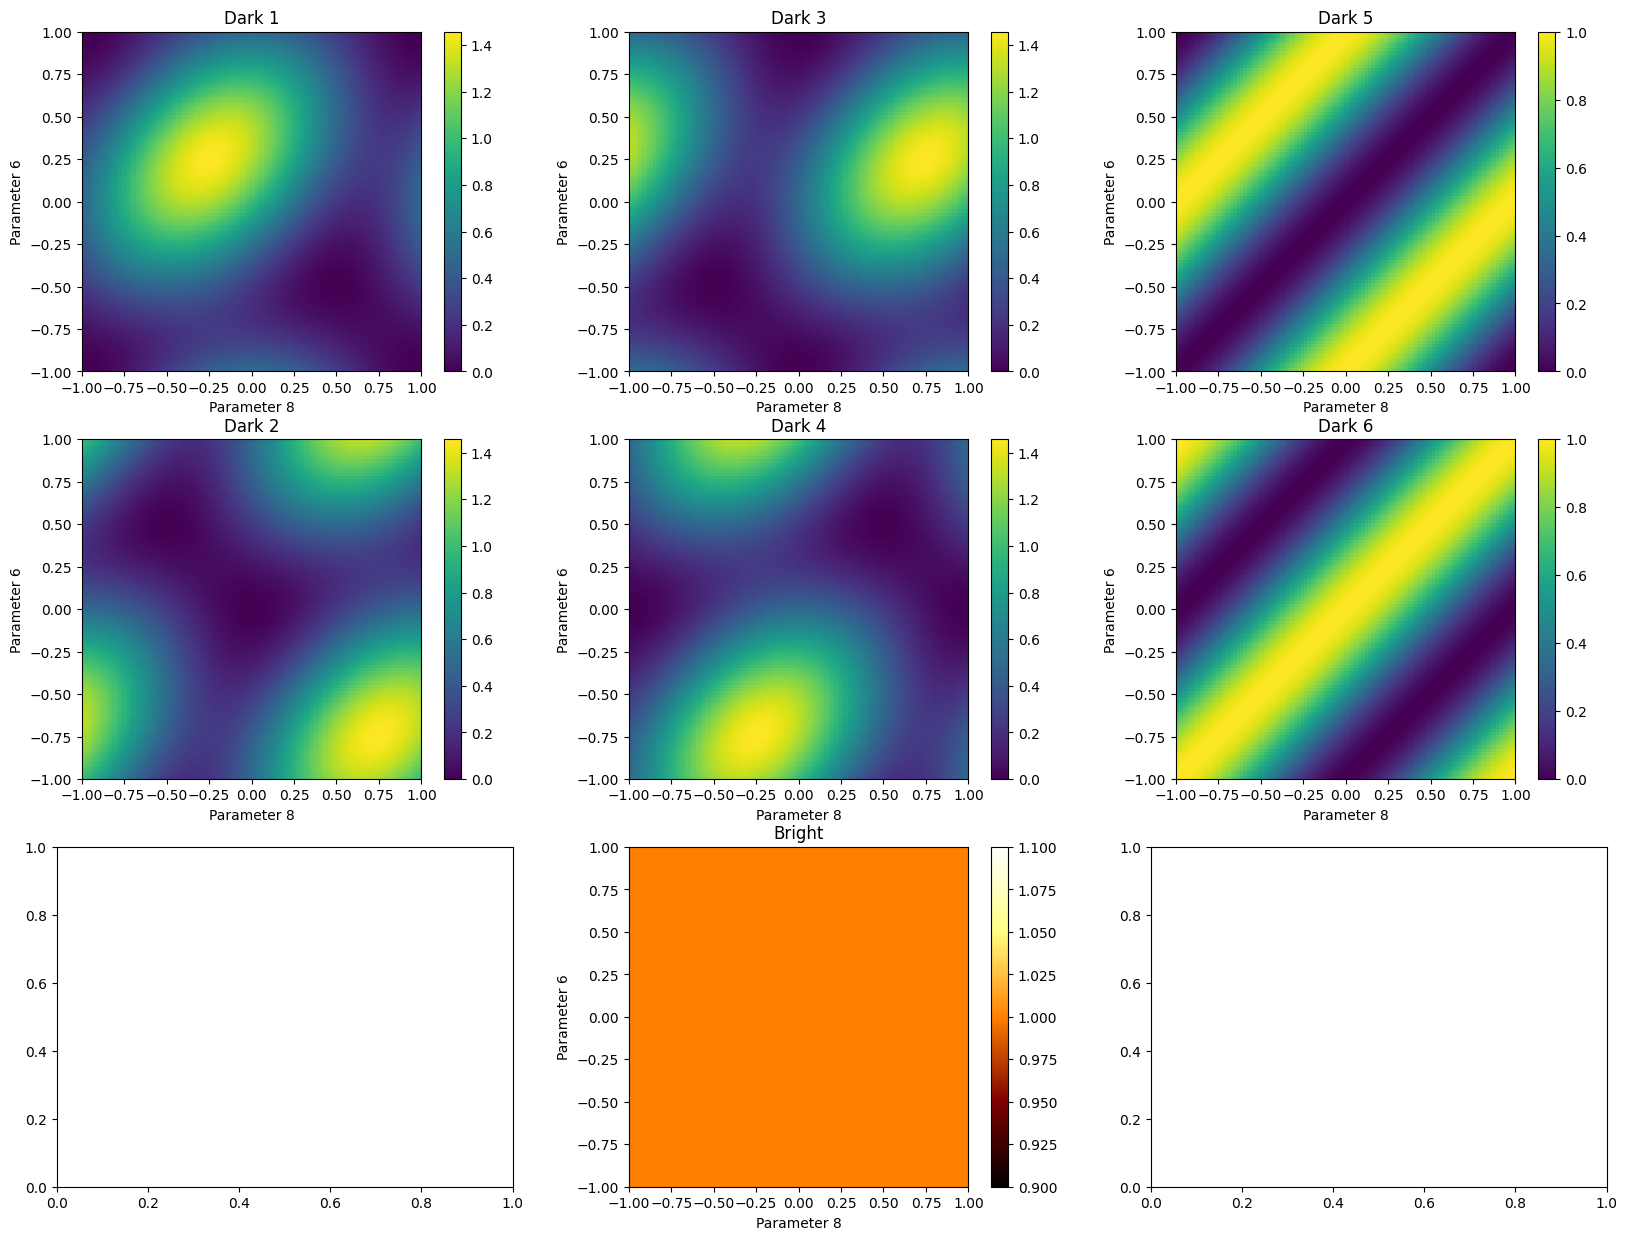

In [20]:
def scan(plot_intermediate_states=False):
    
    scan_on_parameters = (6,8) # Select 2 values from 1 to 14

    # Scan shift power parameter space
    scan = np.linspace(-1, 1, 101)
    null_depths = np.zeros((6, len(scan), len(scan)))
    brights = np.zeros((len(scan), len(scan)))
    first_layer_nulls = np.zeros((4, len(scan), len(scan)))
    second_layer_nulls = np.zeros((4, len(scan), len(scan)))

    if plot_intermediate_states:
        fig_b, axs_b = plt.subplots(2,4, figsize=(20,10))

    fig, axs = plt.subplots(3,3, figsize=(20,15))

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            parameters = [0.5, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            parameters[scan_on_parameters[0]-1] = scan1
            parameters[scan_on_parameters[1]-1] = scan2
            bright, darks, inter = kn0(star_light, parameters)

            if plot_intermediate_states:
                for k, null in enumerate(inter['first_nuller_layer']):
                    first_layer_nulls[k,i,j] = np.abs(null)**2

                for k, null in enumerate(inter['second_nuller_layer']):
                    second_layer_nulls[k,i,j] = np.abs(null)**2

            for k, dark in enumerate(darks):
                null_depths[k,i,j] = np.abs(dark)**2 # np.log(np.abs(dark)**2 / np.abs(bright)**2)
                brights[i,j] = np.abs(bright)**2

    if plot_intermediate_states:
        for k in range(4):
            p = axs_b[0, k]
            p.set_title(f"N{k//2} - {k%2}")
            im = p.imshow(first_layer_nulls[k])
            p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
            p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
            plt.colorbar(im)

        for k in range(4):
            p = axs_b[1, k]
            p.set_title(f"N{k//2+2} - {k%2}")
            im = p.imshow(second_layer_nulls[k])
            p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
            p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
            plt.colorbar(im)

    for k in range(6):
        p = axs[k%2, k//2]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(null_depths[k], extent=[-1, 1, -1, 1])
        p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
        p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
        plt.colorbar(im)

    p = axs[2,1]
    p.set_title(f"Bright")
    im = p.imshow(brights, extent=[-1, 1, -1, 1], cmap="afmhot")
    p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
    p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
    plt.colorbar(im)
    
    plt.show()

scan(False)